In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing import StandardNormalizer, LabelEncoder, DataSplitter, DataPreprocessor
from src.models import RandomForestModel
from src.evaluation import CrossValidator, HyperparameterTuner, MetricsCalculator
from src.visualization import (
    ConfusionMatrixPlotter, ROCCurvePlotter,
    ParameterInfluencePlotter, PredictionScatterPlotter
)
import os

plt.rcParams['figure.dpi'] = 110
plt.style.use('seaborn-v0_8-darkgrid')

output_dir = 'heart_rf_output'
os.makedirs(output_dir, exist_ok=True)

polish_labels = {
    'age': 'Wiek',
    'sex': 'Płeć',
    'cp': 'Typ bólu w klatce',
    'trestbps': 'Ciśnienie spoczynkowe',
    'chol': 'Cholesterol',
    'fbs': 'Cukier na czczo >120 mg/dl',
    'restecg': 'EKG spoczynkowe',
    'thalach': 'Maksymalne tętno',
    'exang': 'Ból wysiłkowy',
    'oldpeak': 'Obniżenie ST',
    'slope': 'Nachylenie ST',
    'ca': 'Naczynia barwione',
    'thal': 'Niedokrwistość tarczowatokrwinkowa',
    'condition': 'Choroba serca'
}

def pl(c):
    return polish_labels.get(c, c)

print(f"✓ Utworzono katalog wyników: {output_dir}")

✓ Utworzono katalog wyników: heart_rf_output


In [2]:
import inspect
print("ROCCurvePlotter.plot signature:")
print(inspect.signature(ROCCurvePlotter.plot))

ROCCurvePlotter.plot signature:
(self, y_true, y_pred_proba, n_classes, title='Krzywe ROC', class_names=None)


## 1. Wczytanie i Przetwarzanie Danych


In [3]:
df = pd.read_csv('datasets/heart_cleveland_upload.csv')
X = df.drop('condition', axis=1)
y = df['condition']
print(f"Rozmiar zbioru (cechy): {X.shape}")
print(f"Klasy Choroba serca: {sorted(y.unique())}")
print("\nRozkład klas:")
class_counts = y.value_counts().sort_index()
class_df = class_counts.rename('count').to_frame()
class_df['percentage'] = class_df['count'] / len(y) * 100
for cls, row in class_df.iterrows():
    print(f"  Klasa {cls}: {row.count} ({row.percentage:.2f}%)")
class_df.to_csv(f"{output_dir}/class_distribution.csv")
print(f"✓ Zapisano: {output_dir}/class_distribution.csv")
print("\nPrzykładowe wiersze:")
print(df.head())
print("\nMapa etykiet kolumn (ang -> pl):")
for c in list(X.columns)[:10]:
    print(f"  {c} -> {pl(c)}")

Rozmiar zbioru (cechy): (297, 13)
Klasy Choroba serca: [np.int64(0), np.int64(1)]

Rozkład klas:
  Klasa 0: <bound method Series.count of count         160.000000
percentage     53.872054
Name: 0, dtype: float64> (53.87%)
  Klasa 1: <bound method Series.count of count         137.000000
percentage     46.127946
Name: 1, dtype: float64> (46.13%)
✓ Zapisano: heart_rf_output/class_distribution.csv

Przykładowe wiersze:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0       

In [4]:
splitter = DataSplitter(test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = splitter.split(X, y)
normalizer = StandardNormalizer()
label_encoder = LabelEncoder()
preprocessor = DataPreprocessor(normalizer, label_encoder)
X_train_norm, X_test_norm = preprocessor.preprocess_features(X_train, X_test)
y_train_enc, y_test_enc = preprocessor.preprocess_labels(y_train, y_test)
print(f"Zbiór treningowy: {X_train_norm.shape}")
print(f"Zbiór testowy: {X_test_norm.shape}")
print(f"Liczba klas: {preprocessor.get_num_classes()}")

condition_name_map = {0: 'Brak choroby', 1: 'Choroba'}
encoded_class_labels = {}
if getattr(preprocessor.label_encoder, 'classes_', None) is not None:
    for original_label in preprocessor.label_encoder.classes_:
        encoded_val = int(preprocessor.label_encoder.encoder.transform([original_label])[0])
        encoded_class_labels[encoded_val] = condition_name_map.get(original_label, str(original_label))
class_display_names = [encoded_class_labels.get(idx, str(idx)) for idx in range(preprocessor.get_num_classes())]
metric_name_map = {
    'accuracy': 'Dokładność',
    'precision': 'Precyzja',
    'recall': 'Czułość',
    'f1_score': 'Miara F1',
    'roc_auc': 'ROC-AUC',
    'mse': 'MSE',
    'mae': 'MAE',
    'rmse': 'RMSE'
}

Zbiór treningowy: (267, 13)
Zbiór testowy: (30, 13)
Liczba klas: 2


## 2. Walidacja Krzyżowa (5-Fold CV)


In [5]:
rf_model = RandomForestModel(n_estimators=100, random_state=42)
tuner = HyperparameterTuner(search_type='grid', cv=5)
param_space = rf_model.get_param_grid()
print("Rozpoczynam tuning Random Forest...")
rf_model, cv_results = tuner.tune(rf_model, X_train_norm, y_train_enc, param_space)
print(f"Najlepsze parametry: {tuner.best_params_}")
print(f"Najlepszy wynik CV (accuracy): {tuner.best_score_:.4f}")
cv_df = pd.DataFrame(cv_results)
if 'mean_test_neg_mean_squared_error' in cv_df.columns:
    cv_df['mean_test_mse'] = -cv_df['mean_test_neg_mean_squared_error']
    cv_df['std_test_mse'] = cv_df.get('std_test_neg_mean_squared_error', np.nan)
if 'mean_test_neg_mean_absolute_error' in cv_df.columns:
    cv_df['mean_test_mae'] = -cv_df['mean_test_neg_mean_absolute_error']
    cv_df['std_test_mae'] = cv_df.get('std_test_neg_mean_absolute_error', np.nan)
cv_df.to_csv(f"{output_dir}/rf_hyperparam_cv_results_raw.csv", index=False)
print(f"✓ Zapisano wyniki CV: {output_dir}/rf_hyperparam_cv_results_raw.csv")
rank_candidates = [col for col in ['rank_test_accuracy', 'rank_test_score'] if col in cv_df.columns]
if rank_candidates:
    best_idx = int(cv_df[rank_candidates[0]].idxmin())
else:
    metric_candidates = ['mean_test_accuracy', 'mean_test_score']
    best_metric_col = next((col for col in metric_candidates if col in cv_df.columns), None)
    best_idx = int(cv_df[best_metric_col].idxmax()) if best_metric_col else 0
best_row = cv_df.loc[best_idx]
cv_scores = {}
summary_metric_candidates = {
    'accuracy': [('mean_test_accuracy', 1.0), ('mean_test_score', 1.0)],
    'precision_macro': [('mean_test_precision_macro', 1.0)],
    'recall_macro': [('mean_test_recall_macro', 1.0)],
    'roc_auc_ovr': [('mean_test_roc_auc_ovr', 1.0)],
    'mse': [('mean_test_mse', 1.0), ('mean_test_neg_mean_squared_error', -1.0)],
    'mae': [('mean_test_mae', 1.0), ('mean_test_neg_mean_absolute_error', -1.0)]
}
for metric_name, candidates in summary_metric_candidates.items():
    for col, multiplier in candidates:
        if col in best_row and pd.notna(best_row[col]):
            cv_scores[f"{metric_name}_mean"] = float(best_row[col]) * multiplier
            break
print("Wybrane metryki najlepszego modelu (CV):")
for key, value in cv_scores.items():
    print(f"  {key}: {value:.4f}")

Rozpoczynam tuning Random Forest...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy wynik CV (accuracy): 0.8275
✓ Zapisano wyniki CV: heart_rf_output/rf_hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.8275
  precision_macro_mean: 0.8324
  recall_macro_mean: 0.8225
  roc_auc_ovr_mean: 0.8225
  mse_mean: 0.1725
  mae_mean: 0.1725
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy wynik CV (accuracy): 0.8275
✓ Zapisano wyniki CV: heart_rf_output/rf_hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.8275
  precision_macro_mean: 0.8324
  recall_macro_mean: 0.8225
  roc_auc_ovr_mean: 0.8225
  mse_mean: 0.1725
  mae_mean: 0.1725


✓ Zapisano: heart_rf_output/rf_epoki_metryki.csv


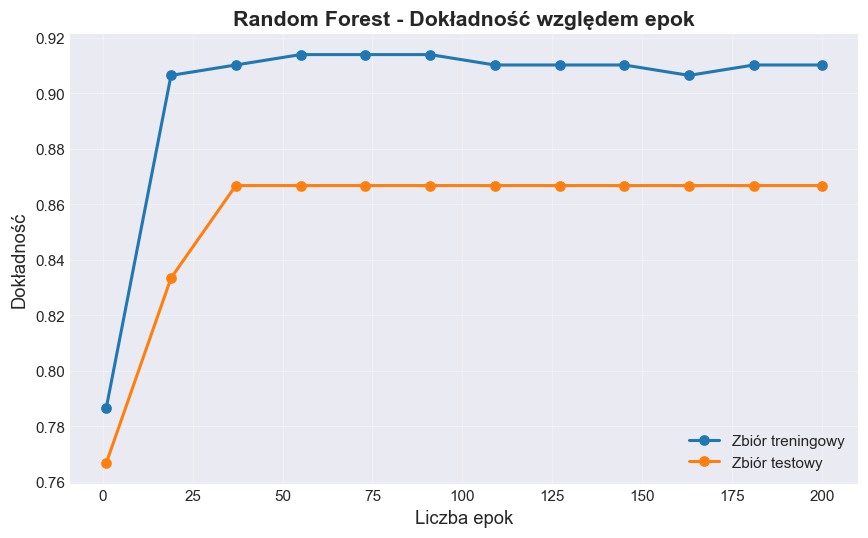

✓ Zapisano: heart_rf_output/rf_epoki_dokładność.png


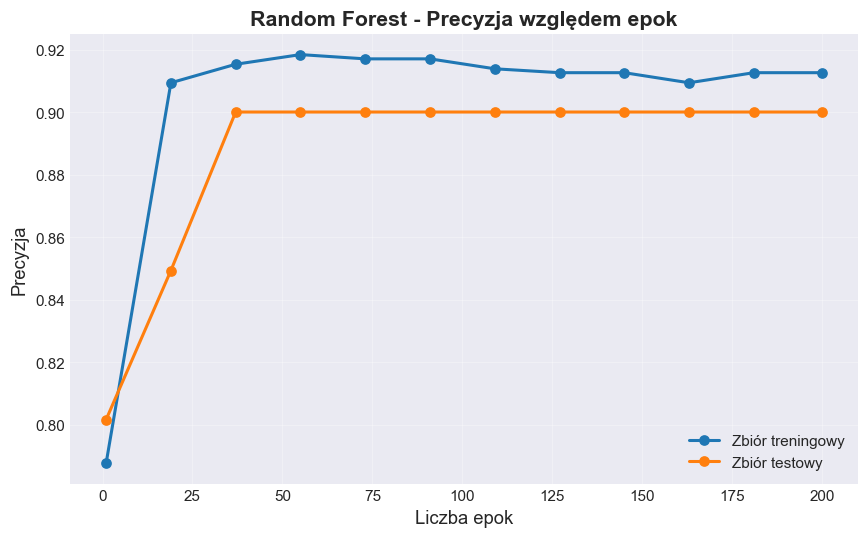

✓ Zapisano: heart_rf_output/rf_epoki_precyzja.png


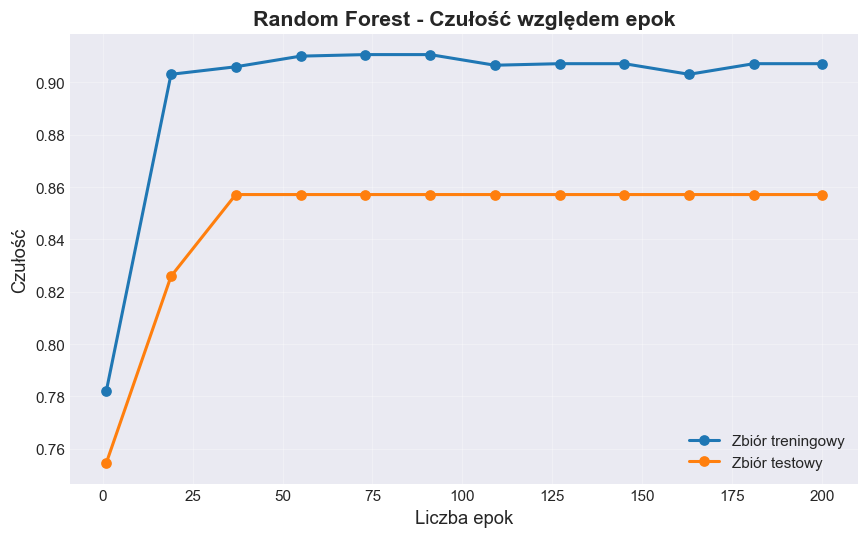

✓ Zapisano: heart_rf_output/rf_epoki_czułość.png


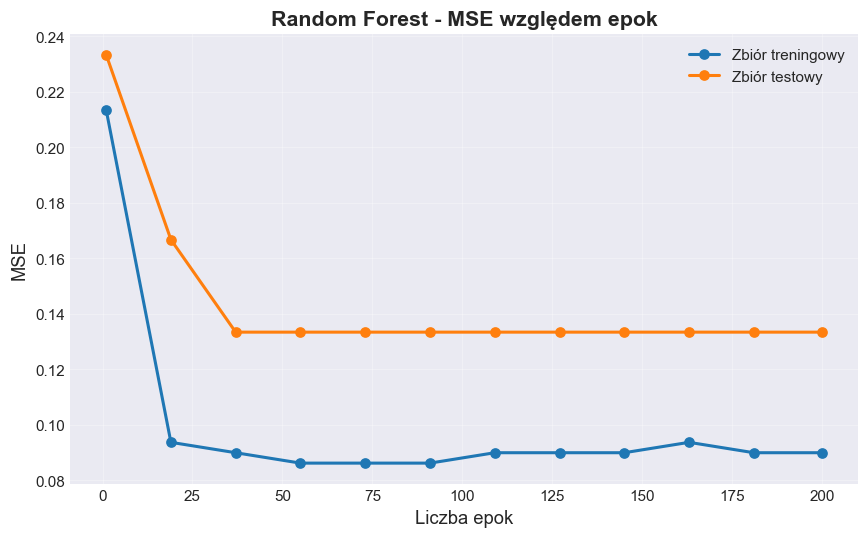

✓ Zapisano: heart_rf_output/rf_epoki_mse.png


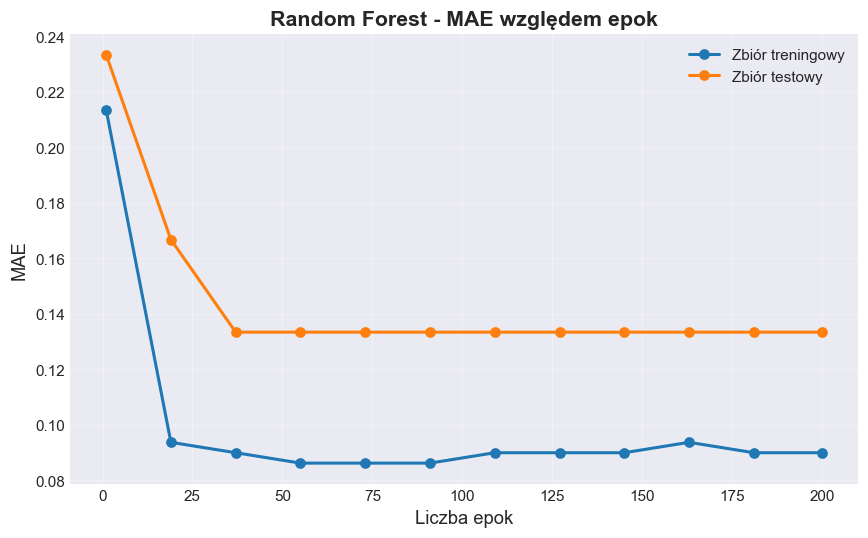

✓ Zapisano: heart_rf_output/rf_epoki_mae.png


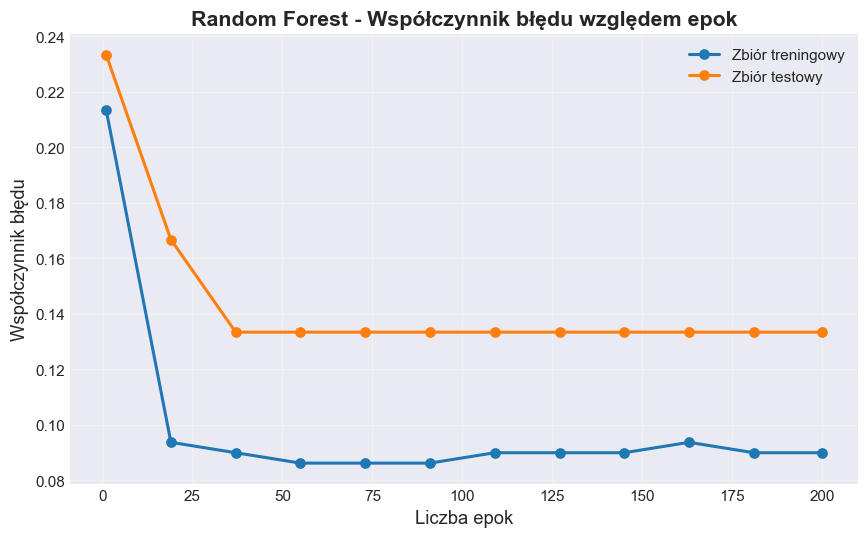

✓ Zapisano: heart_rf_output/rf_epoki_blad.png


In [6]:
from sklearn.ensemble import RandomForestClassifier
metrics_calc_epoch = MetricsCalculator(average='macro')
base_params = rf_model.get_params()
max_epochs = int(base_params.get('n_estimators', 100))
epoch_values = np.linspace(1, max_epochs, num=min(max_epochs, 12), dtype=int)
epoch_values = np.unique(epoch_values)
epoch_records = []
for epoch in epoch_values:
    params = base_params.copy()
    params['n_estimators'] = int(epoch)
    estimator = RandomForestClassifier(**params)
    estimator.fit(X_train_norm, y_train_enc)
    for subset_name, X_subset, y_subset in [('Trening', X_train_norm, y_train_enc), ('Test', X_test_norm, y_test_enc)]:
        preds = estimator.predict(X_subset)
        probas = estimator.predict_proba(X_subset)
        classification = metrics_calc_epoch.calculate_classification_metrics(y_subset, preds)
        errors = metrics_calc_epoch.calculate_error_metrics(y_subset, preds)
        roc_auc_val = metrics_calc_epoch.calculate_roc_auc(y_subset, probas)
        if roc_auc_val is None:
            roc_auc_val = np.nan
        epoch_records.append({
            'Epoka': int(epoch),
            'Zestaw': subset_name,
            'Dokładność': classification['accuracy'],
            'Precyzja': classification['precision'],
            'Czułość': classification['recall'],
            'ROC_AUC': roc_auc_val,
            'MSE': errors['mse'],
            'MAE': errors['mae']
        })
epoch_metrics_df = pd.DataFrame(epoch_records)
epoch_metrics_df['Współczynnik błędu'] = 1.0 - epoch_metrics_df['Dokładność']
epoch_metrics_df.to_csv(f"{output_dir}/rf_epoki_metryki.csv", index=False)
print(f"✓ Zapisano: {output_dir}/rf_epoki_metryki.csv")
label_map = {'Trening': 'Zbiór treningowy', 'Test': 'Zbiór testowy'}
metrics_to_plot = [
    ('Dokładność', 'Random Forest - Dokładność względem epok'),
    ('Precyzja', 'Random Forest - Precyzja względem epok'),
    ('Czułość', 'Random Forest - Czułość względem epok'),
    ('MSE', 'Random Forest - MSE względem epok'),
    ('MAE', 'Random Forest - MAE względem epok')
]
for metric_name, plot_title in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for dataset_name in ['Trening', 'Test']:
        subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
        plt.plot(subset['Epoka'], subset[metric_name], marker='o', linewidth=2, label=label_map[dataset_name])
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Liczba epok', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/rf_epoki_{metric_name.lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Zapisano: {output_dir}/rf_epoki_{metric_name.lower()}.png")
plt.figure(figsize=(8, 5))
for dataset_name in ['Trening', 'Test']:
    subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
    plt.plot(subset['Epoka'], subset['Współczynnik błędu'], marker='o', linewidth=2, label=label_map[dataset_name])
plt.title('Random Forest - Współczynnik błędu względem epok', fontsize=14, fontweight='bold')
plt.xlabel('Liczba epok', fontsize=12)
plt.ylabel('Współczynnik błędu', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/rf_epoki_blad.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/rf_epoki_blad.png")

## 3. Optymalizacja Hiperparametrów


In [7]:
print("Podsumowanie wyników tuningu:")
print(f"Najlepsze parametry: {tuner.best_params_}")
print(f"Najlepszy wynik CV (accuracy): {tuner.best_score_:.4f}")

Podsumowanie wyników tuningu:
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy wynik CV (accuracy): 0.8275


## 4. Trening Finalnego Modelu


In [8]:
rf_model.fit(X_train_norm, y_train_enc)
training_time = rf_model.get_training_time()

print(f"Model wytrenowany pomyślnie!")
print(f"Czas treningu: {training_time:.3f} sekund")

Model wytrenowany pomyślnie!
Czas treningu: 0.403 sekund


## 5. Ewaluacja na Zbiorze Testowym


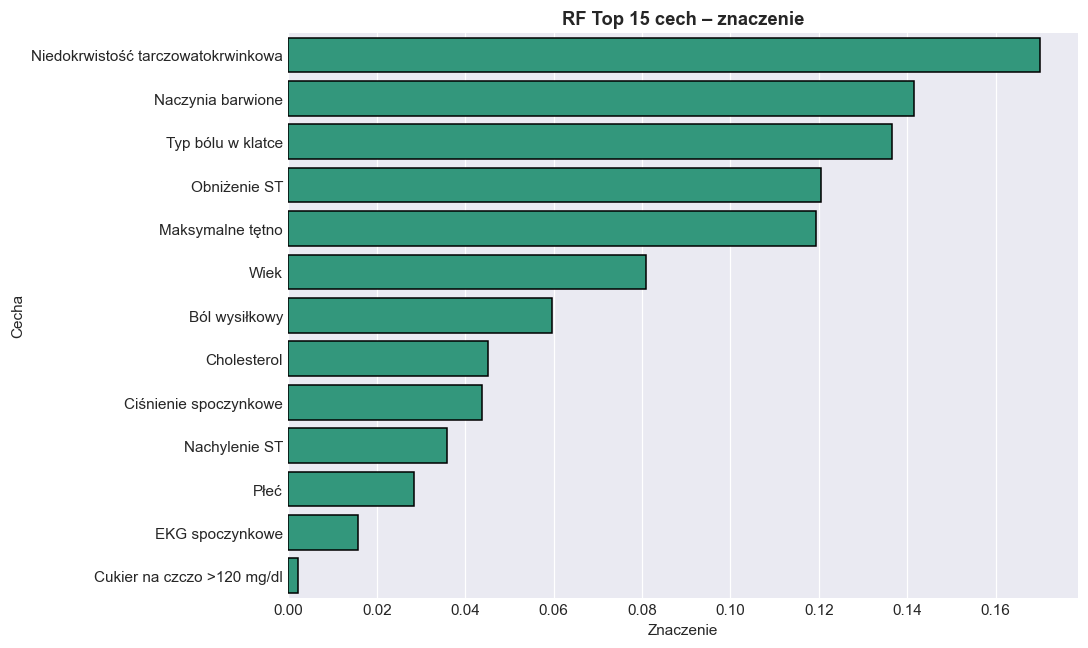

✓ Zapisano: rf_feature_importances.csv oraz rf_feature_importances_top15.png


In [9]:
if hasattr(rf_model.model, 'feature_importances_'):
    fi = rf_model.model.feature_importances_
    fi_df = pd.DataFrame({'feature': X_train.columns, 'importance': fi, 'feature_pl': [pl(c) for c in X_train.columns]}).sort_values('importance', ascending=False)
    fi_df.to_csv(f"{output_dir}/rf_feature_importances.csv", index=False)
    plt.figure(figsize=(10,6))
    sns.barplot(
        x='importance',
        y='feature_pl',
        data=fi_df.head(15),
        color=plt.colormaps.get('viridis')(0.6),
        edgecolor='black'
    )
    plt.title('RF Top 15 cech – znaczenie', fontweight='bold')
    plt.xlabel('Znaczenie')
    plt.ylabel('Cecha')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/rf_feature_importances_top15.png", dpi=300)
    plt.show()
    print(f"✓ Zapisano: rf_feature_importances.csv oraz rf_feature_importances_top15.png")
else:
    print("⚠ Brak importance")

In [10]:
y_pred = rf_model.predict(X_test_norm)
y_pred_proba = rf_model.predict_proba(X_test_norm)

metrics_calc = MetricsCalculator(average='macro')
metrics = metrics_calc.calculate_all_metrics(y_test_enc, y_pred, y_pred_proba)

print("Metryki na zbiorze testowym:")
print("="*50)
for metric_key, value in metrics.items():
    if metric_key == 'confusion_matrix':
        continue
    metric_label = metric_name_map.get(metric_key, metric_key)
    if value is None:
        print(f"{metric_label:25s}: brak danych")
    elif isinstance(value, (int, float, np.floating)):
        print(f"{metric_label:25s}: {float(value):.4f}")
    else:
        print(f"{metric_label:25s}: {value}")

Metryki na zbiorze testowym:
Dokładność               : 0.8667
Precyzja                 : 0.9000
Czułość                  : 0.8571
MSE                      : 0.1333
MAE                      : 0.1333
RMSE                     : 0.3651
ROC-AUC                  : 0.9509


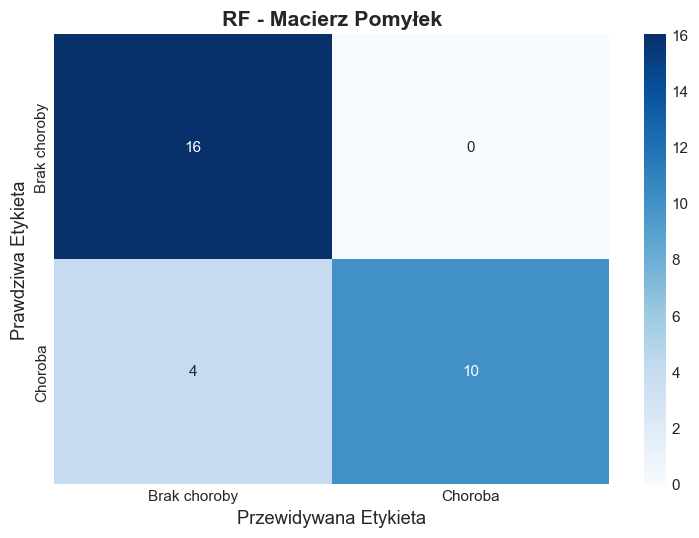

✓ Zapisano: heart_rf_output/rf_confusion_matrix.png


In [11]:
cm_plotter = ConfusionMatrixPlotter(figsize=(7, 5))
fig_cm = cm_plotter.plot(metrics['confusion_matrix'],
                         class_names=class_display_names,
                         title='RF - Macierz Pomyłek')
fig_cm.savefig(f"{output_dir}/rf_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/rf_confusion_matrix.png")

## 6. Wizualizacje


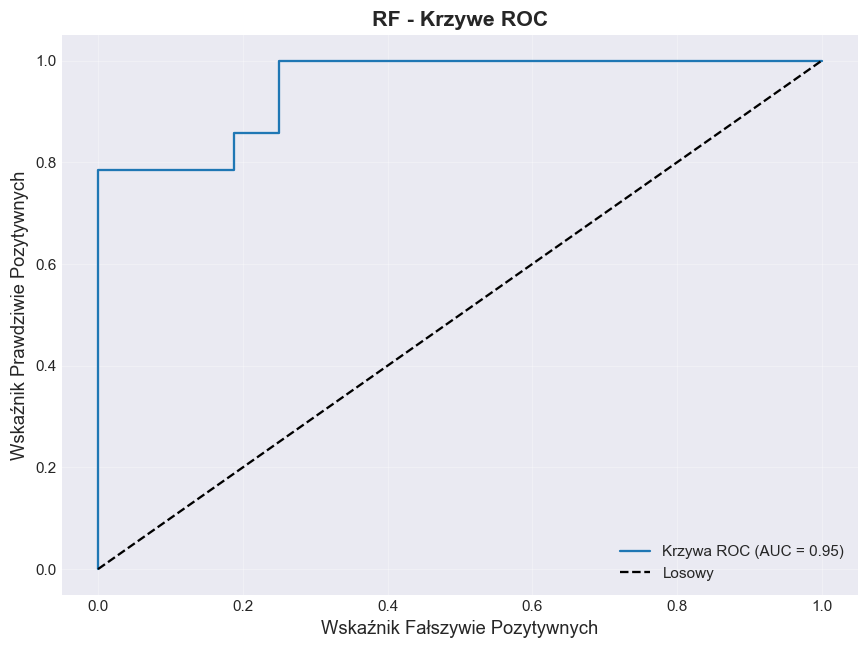

✓ Zapisano: heart_rf_output/rf_roc_curves.png


In [12]:
roc_plotter = ROCCurvePlotter(figsize=(8,6))
fig_roc = roc_plotter.plot(y_test_enc, y_pred_proba, preprocessor.get_num_classes(), title='RF - Krzywe ROC', class_names=class_display_names)
fig_roc.savefig(f"{output_dir}/rf_roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/rf_roc_curves.png")

              precision    recall  f1-score   support

Brak choroby       0.80      1.00      0.89        16
     Choroba       1.00      0.71      0.83        14

    accuracy                           0.87        30
   macro avg       0.90      0.86      0.86        30
weighted avg       0.89      0.87      0.86        30

Błędne klasyfikacje: 4 (13.33%)
  Klasa rzeczywista Klasa przewidywana  Prawdopodobieństwo choroby
0      Brak choroby       Brak choroby                    0.128971
1      Brak choroby       Brak choroby                    0.151023
2      Brak choroby       Brak choroby                    0.380358
3           Choroba       Brak choroby                    0.370535
4      Brak choroby       Brak choroby                    0.102127


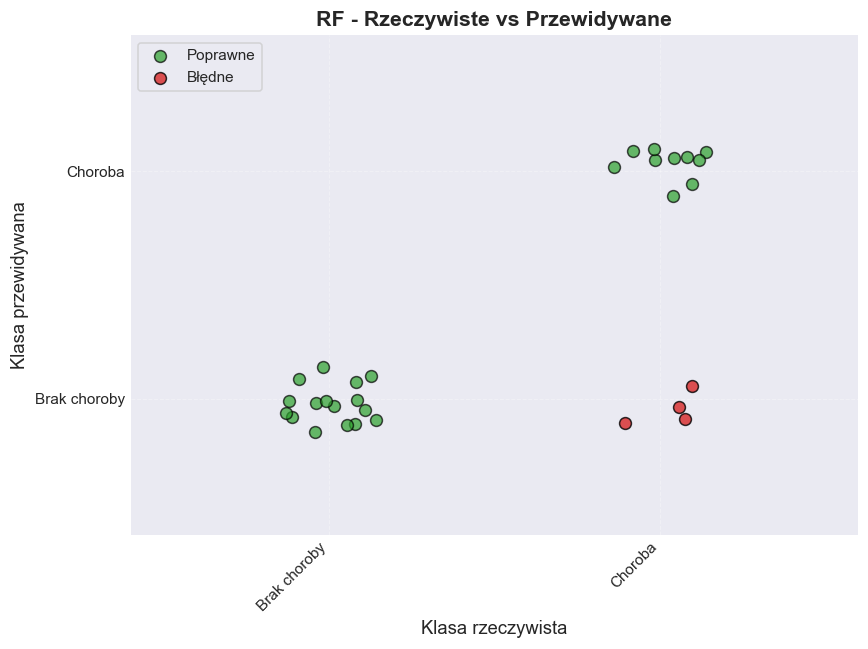

✓ Zapisano: heart_rf_output/rf_prediction_scatter.png


In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_test_enc, y_pred, target_names=class_display_names)
with open(f"{output_dir}/rf_classification_report.txt","w") as f:
    f.write(report)
print(report)
mis_idx = np.where(y_test_enc != y_pred)[0]
print(f"Błędne klasyfikacje: {len(mis_idx)} ({len(mis_idx)/len(y_test_enc)*100:.2f}%)")

def decode_label(idx):
    idx = int(idx)
    if 0 <= idx < len(class_display_names):
        return class_display_names[idx]
    return str(idx)

sample_df = pd.DataFrame({
    'Klasa rzeczywista': [decode_label(idx) for idx in y_test_enc[:15]],
    'Klasa przewidywana': [decode_label(idx) for idx in y_pred[:15]],
    'Prawdopodobieństwo choroby': y_pred_proba[:15,1]
})
sample_df.to_csv(f"{output_dir}/rf_sample_predictions_head15.csv", index=False)
print(sample_df.head())
scatter_plotter = PredictionScatterPlotter(figsize=(8,6))
fig_sc = scatter_plotter.plot(
    y_test_enc,
    y_pred,
    title='RF - Rzeczywiste vs Przewidywane',
    class_labels=encoded_class_labels
)
fig_sc.savefig(f"{output_dir}/rf_prediction_scatter.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/rf_prediction_scatter.png")

In [14]:
print("="*70)
print("PODSUMOWANIE RANDOM FOREST")
print("="*70)
print(f"Najlepsze parametry: {tuner.best_params_}")
print(f"Najlepsza dokładność CV: {tuner.best_score_:.4f}")
print(f"Czas treningu: {training_time:.3f}s")
print("\nMetryki testowe:")
for metric_key, value in metrics.items():
    if metric_key == 'confusion_matrix':
        continue
    metric_label = metric_name_map.get(metric_key, metric_key)
    if value is None:
        print(f"  {metric_label}: brak danych")
    elif isinstance(value, (int, float, np.floating)):
        print(f"  {metric_label}: {float(value):.4f}")
    else:
        print(f"  {metric_label}: {value}")
if 'fi_df' in globals():
    print("\nTop 5 cech:")
    print(fi_df.head(5)[['feature','feature_pl','importance']])
print("="*70)

PODSUMOWANIE RANDOM FOREST
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Najlepsza dokładność CV: 0.8275
Czas treningu: 0.403s

Metryki testowe:
  Dokładność: 0.8667
  Precyzja: 0.9000
  Czułość: 0.8571
  MSE: 0.1333
  MAE: 0.1333
  RMSE: 0.3651
  ROC-AUC: 0.9509

Top 5 cech:
    feature                          feature_pl  importance
12     thal  Niedokrwistość tarczowatokrwinkowa    0.170147
11       ca                   Naczynia barwione    0.141644
2        cp                   Typ bólu w klatce    0.136501
9   oldpeak                        Obniżenie ST    0.120488
7   thalach                    Maksymalne tętno    0.119280


## 7. Podsumowanie


In [15]:
print("="*60)
print("PODSUMOWANIE - RANDOM FOREST")
print("="*60)
print(f"\nParametry modelu: {tuner.best_params_}")
print(f"\nWyniki CV (5-fold):")
for metric, score in cv_scores.items():
    if 'mean' in metric:
        print(f"  {metric}: {score:.4f}")
print(f"\nWyniki testowe:")
print(f"  {metric_name_map.get('accuracy', 'Dokładność')}: {metrics['accuracy']:.4f}")
print(f"  {metric_name_map.get('precision', 'Precyzja')}: {metrics['precision']:.4f}")
print(f"  {metric_name_map.get('recall', 'Czułość')}: {metrics['recall']:.4f}")
roc_auc_value = metrics.get('roc_auc', None)
if roc_auc_value is not None:
    print(f"  {metric_name_map.get('roc_auc', 'ROC-AUC')}: {roc_auc_value:.4f}")
else:
    print(f"  {metric_name_map.get('roc_auc', 'ROC-AUC')}: brak danych")
print(f"\nCzas treningu: {training_time:.3f}s")
print("="*60)

PODSUMOWANIE - RANDOM FOREST

Parametry modelu: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Wyniki CV (5-fold):
  accuracy_mean: 0.8275
  precision_macro_mean: 0.8324
  recall_macro_mean: 0.8225
  roc_auc_ovr_mean: 0.8225
  mse_mean: 0.1725
  mae_mean: 0.1725

Wyniki testowe:
  Dokładność: 0.8667
  Precyzja: 0.9000
  Czułość: 0.8571
  ROC-AUC: 0.9509

Czas treningu: 0.403s
